In [1]:
import numpy as np
import pandas as pd
import pymc3 as pm
import arviz as az
from plotnine import *
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

### Generating example data

+ `n_accounts` are created per day
+ Assume normally distributed mu=900, sigma=200
+ Create for 1000 days

In [2]:
# Note: random must get size keyword
n_samples = 5000
accounts_per_day = pm.Normal.dist(900, 200).random(size=n_samples)
# Alternatively - use truncated normal with some arbitrary lower bound
# accounts_per_day = pm.TruncatedNormal.dist(900, 600, lower=50).random(size=1000)
accounts_per_day_df = pd.DataFrame(accounts_per_day, columns=['n_accounts']).astype(int).reset_index().rename(columns={'index':'day'})
accounts_per_day_df

,day,n_accounts
0,0,918
1,1,663
2,2,1038
3,3,833
4,4,814
...,...,...
4995,4995,761
4996,4996,789
4997,4997,1145
4998,4998,741


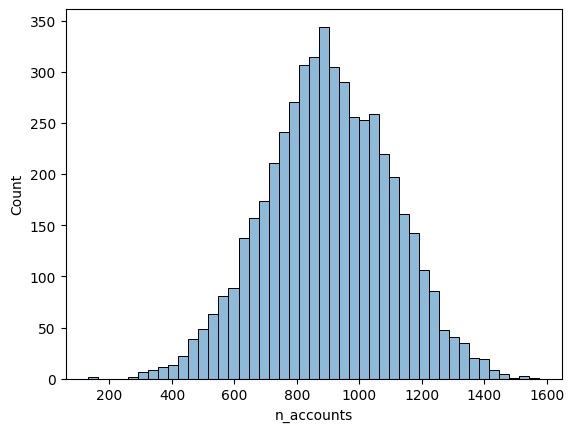

In [3]:
sns.histplot(accounts_per_day_df['n_accounts'], stat='count', discrete=False, alpha=0.5);

+ Some proportion of these accounts created in a day are fraudulent, and the rest are pukka
+ **The number of fraudulent accounts created per day is described by a proportion p - binomially distributed**

In [4]:
p_fraud = 0.34
n_fraudulent = pm.Binomial.dist(n=accounts_per_day, p=p_fraud).random(size=n_samples)
accounts_per_day_df = accounts_per_day_df.assign(n_fraudulent=n_fraudulent)
accounts_per_day_df['fraudulent_prop'] = accounts_per_day_df['n_fraudulent'] / accounts_per_day_df['n_accounts']
accounts_per_day_df['n_genuine'] = accounts_per_day_df['n_accounts'] - accounts_per_day_df['n_fraudulent']
accounts_per_day_df

,day,n_accounts,n_fraudulent,fraudulent_prop,n_genuine
0,0,918,316,0.344227,602
1,1,663,233,0.351433,430
2,2,1038,360,0.346821,678
3,3,833,311,0.373349,522
4,4,814,278,0.341523,536
...,...,...,...,...,...
4995,4995,761,249,0.327201,512
4996,4996,789,269,0.340938,520
4997,4997,1145,403,0.351965,742
4998,4998,741,268,0.361673,473


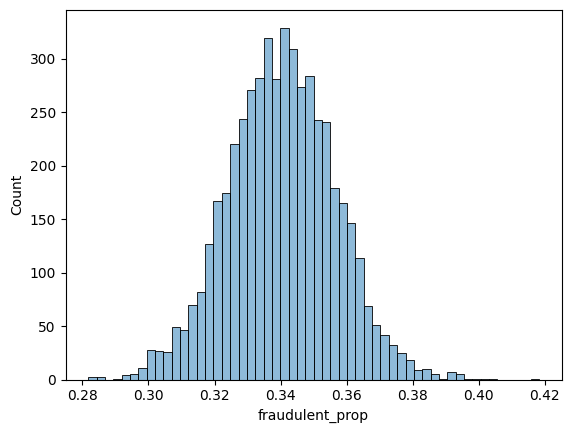

In [5]:
sns.histplot(accounts_per_day_df['fraudulent_prop'], stat='count', discrete=False, alpha=0.5);

+ We do not get to see the correct number of good and fraudulent accounts - we see a noisy version of these numbers
+ But the noisy versions of these numbers are constrained by some other assumptions:
    + If we see a fraudulent account, we can classify it as fraudulent or don't know. We never classify it as genuine.
    + If we see a genuine account, we can classify it as genuine or don't know. We never classify it as fraudulent.
+ So, if 100 fraudulent accounts are created on a particular day, our measuring system can only detect a subset of them - Our measurement system will not count 101 fraudulent accounts, but it can feasibly observe 100 or 99 of them but more likely some lower unknown proportion of the fraudulent accounts.
+ This means we can apply a binomial distribution to the fraudulent accounts and the genuine accounts to get the accounts that we observe as good, fraudulent, unknown.
+ We will assume that the fraud detection, and the non-fraudulent detection works with detection rate a proportion p binomilly distributed
+ This is probably a poor assumption - maybe better to work with 2 different detection rates for frauds and koshers

+ So, in a particular day (if we are god) we see a row of data that has
    + `n_accounts` - total accounts created that day - normally distributed: mu, sigma
    + `n_frauds` - some number of accounts that are frauds - binomially distributed: n_accounts, p_fraud
    + `n_genuines`  = n_accounts - n_frauds
    + `n_obs_frauds` - some number of accounts that we have assessed/measured and ascertained to be frauds. A proportion of the frauds binomially distributed - p_detect
    + `n_obs_genuines` - some number of accounts that we have assessed/measured and ascertained to be genuine. A proportion of the genuines binomially distributed - p_detect
    + `n_obs_unknown` - n_accounts - n_obs_frauds - n_obs_genuines
    
+ But, for mortals we see a row of data that has
    + `n_accounts` - total accounts created that day - normally distributed: mu, sigma
    + `n_obs_frauds` - some number of accounts that we have assessed/measured and ascertained to be frauds. A proportion of the frauds binomially distributed - p_detect_fraud
    + `n_obs_genuines` - some number of accounts that we have assessed/measured and ascertained to be genuine. A proportion of the genuines binomially distributed - p_detect_genuine
    + `n_obs_unknown` - n_accounts - n_obs_frauds - n_obs_genuines

In [6]:
# Change detection rates to see impact of relative difference between measurement system detection rates
# If rates are same, then can infer the actual fraudulent proportion by using the observed fraudulent rate
p_detect_fraud = 0.10
p_detect_genuine = 0.40
n_obs_fraudulent = pm.Binomial.dist(n_fraudulent, p=p_detect_fraud).random(size=n_samples)
n_obs_genuine = pm.Binomial.dist(accounts_per_day_df['n_genuine'].values, p=p_detect_genuine).random(size=n_samples)
accounts_per_day_df['n_obs_fraudulent'] = n_obs_fraudulent
accounts_per_day_df['n_obs_genuine'] = n_obs_genuine
accounts_per_day_df['n_obs_unknown'] = accounts_per_day_df['n_accounts'].values - n_obs_fraudulent - n_obs_genuine
accounts_per_day_df = accounts_per_day_df.copy()[['day', 'n_accounts', 'n_genuine', 'n_fraudulent', 'fraudulent_prop', 'n_obs_genuine', 'n_obs_fraudulent', 'n_obs_unknown']]
accounts_per_day_df['obs_fraudulent_prop'] = accounts_per_day_df['n_obs_fraudulent'] / (accounts_per_day_df['n_obs_fraudulent'] + accounts_per_day_df['n_obs_genuine'])
accounts_per_day_df

,day,n_accounts,n_genuine,n_fraudulent,fraudulent_prop,n_obs_genuine,n_obs_fraudulent,n_obs_unknown,obs_fraudulent_prop
0,0,918,602,316,0.344227,255,31,632,0.108392
1,1,663,430,233,0.351433,160,25,478,0.135135
2,2,1038,678,360,0.346821,259,34,745,0.116041
3,3,833,522,311,0.373349,220,32,581,0.126984
4,4,814,536,278,0.341523,203,25,586,0.109649
...,...,...,...,...,...,...,...,...,...
4995,4995,761,512,249,0.327201,230,22,509,0.087302
4996,4996,789,520,269,0.340938,217,21,551,0.088235
4997,4997,1145,742,403,0.351965,278,42,825,0.131250
4998,4998,741,473,268,0.361673,170,27,544,0.137056


In [7]:
accounts_per_day_df.describe()

,day,n_accounts,n_genuine,n_fraudulent,fraudulent_prop,n_obs_genuine,n_obs_fraudulent,n_obs_unknown,obs_fraudulent_prop
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.00000,5000.000000
mean,2499.500000,900.655200,594.226400,306.428800,0.340334,237.518600,30.606400,632.53020,0.114212
std,1443.520003,202.158873,134.508483,69.859294,0.016210,55.036954,8.683511,142.63766,0.019928
min,0.000000,132.000000,83.000000,48.000000,0.281755,36.000000,3.000000,88.00000,0.044335
25%,1249.750000,765.750000,505.000000,258.000000,0.329375,201.000000,24.000000,537.00000,0.100383
50%,2499.500000,898.000000,591.000000,305.000000,0.340356,236.000000,30.000000,631.00000,0.113971
75%,3749.250000,1043.000000,687.000000,355.000000,0.351162,276.000000,36.000000,732.00000,0.127168
max,4999.000000,1575.000000,1028.000000,547.000000,0.418259,427.000000,66.000000,1103.00000,0.201258


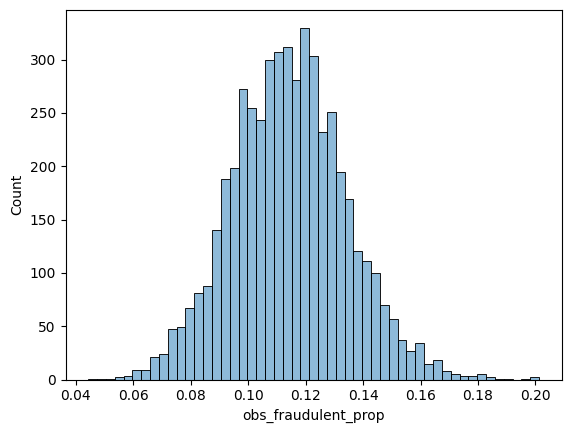

In [8]:
sns.histplot(accounts_per_day_df['obs_fraudulent_prop'], stat='count', discrete=False, alpha=0.5);

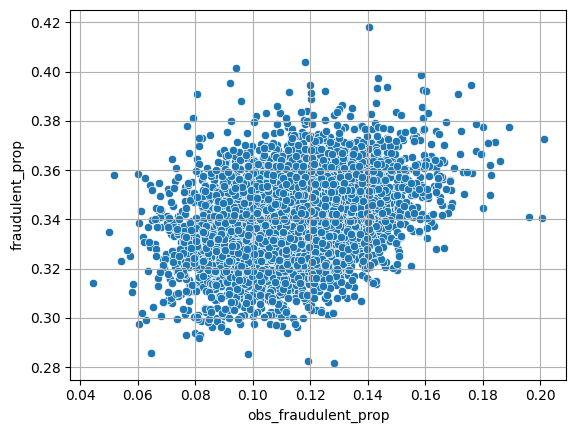

In [9]:
sns.scatterplot(data=accounts_per_day_df, x='obs_fraudulent_prop', y='fraudulent_prop')
plt.grid()
# plt.plot([0.1, 0.6], [0.1, 0.6], linewidth=2, linestyle='dashed', c='r'); #- # 45 degree line for reference

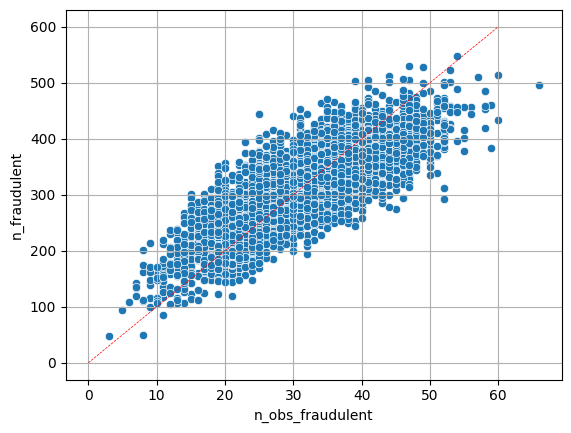

In [10]:
sns.scatterplot(data=accounts_per_day_df, x='n_obs_fraudulent', y='n_fraudulent')
plt.plot([0.0, 60], [0.0, 600], linewidth=0.5, linestyle='dashed', c='r'); #- # 45 degree line for reference
plt.grid()

This relationship looks like:
+ n_fraudulent = slope*n_obs_fraudulent
+ But we have said that our detection system, on average, detects 0.1 of the fraudulent accounts.
+ The slope of the relationship = 1/0.1 = 10, because for every fraudulent account we catch, there are actually an average of 10 total fraudulent accounts
+ So, on a particular day, if we catch 30 fraudulent accounts, we can estimate that 300 fraudulent accounts were actually created. If 1000 total accounts were created that day then the fraudulent rate for that day is estimated at 0.3
+ We also have to take into account the uncertainty, and maybe this can be estimated from the model.
**This is not right - abandon this line of thinking**

## Generating Process 1

In [25]:
p_detect_fraud = 0.50
p_fraud = 0.25
n_samples = 2000

n_accounts = [int(x) for x in pm.TruncatedNormal.dist(mu=900, sigma=200, lower=0).random(size=n_samples)]
n_fraudulent = pm.Binomial.dist(n=n_accounts, p=p_fraud).random(size=n_samples)
n_obs_fraudulent = pm.Binomial.dist(n_fraudulent, p=p_detect_fraud).random(size=n_samples)
df1 = pd.DataFrame({'day': range(n_samples), 'n_accounts': n_accounts, 'n_fraudulent': n_fraudulent, 'n_obs_fraudulent': n_obs_fraudulent})
df1['prop_fraudulent'] = df['n_fraudulent'] / df['n_accounts']
df1['prop_obs_fraudulent'] = df['n_obs_fraudulent'] / df['n_accounts']
df1

,day,n_accounts,n_fraudulent,n_obs_fraudulent,prop_fraudulent,prop_obs_fraudulent
0,0,897,228,107,0.237288,0.126554
1,1,690,182,84,0.237489,0.116200
2,2,1122,288,142,0.258065,0.120737
3,3,743,210,107,0.252366,0.121451
4,4,1074,264,125,0.248049,0.133565
...,...,...,...,...,...,...
1995,1995,834,224,109,0.259287,0.122820
1996,1996,958,238,121,0.241883,0.129870
1997,1997,891,219,105,0.243073,0.124685
1998,1998,906,219,113,0.242356,0.129105


In [31]:
x = pm.Bernoulli.dist(p=0.2).random(size=10)
x

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

## Generating Process 2

In [26]:
p_detect_fraud = 0.50
mu_fraudulent = 100
sigma_fraudulent = 35
n_samples = 2000

n_good_accounts = [int(x) for x in pm.TruncatedNormal.dist(mu=900, sigma=200, lower=0).random(size=n_samples)]
n_fraudulent = [int(x) for x in pm.TruncatedNormal.dist(mu=100, sigma=35, lower=0).random(size=n_samples)]
n_obs_fraudulent = pm.Binomial.dist(n_fraudulent, p=p_detect_fraud).random(size=n_samples)
df2 = pd.DataFrame({'day': range(n_samples), 'n_accounts': n_accounts, 'n_fraudulent': n_fraudulent, 'n_obs_fraudulent': n_obs_fraudulent})
df2['prop_fraudulent'] = df['n_fraudulent'] / df['n_accounts']
df2['prop_obs_fraudulent'] = df['n_obs_fraudulent'] / df['n_accounts']
df2

,day,n_accounts,n_fraudulent,n_obs_fraudulent,prop_fraudulent,prop_obs_fraudulent
0,0,897,62,32,0.237288,0.126554
1,1,690,115,47,0.237489,0.116200
2,2,1122,103,62,0.258065,0.120737
3,3,743,69,33,0.252366,0.121451
4,4,1074,99,51,0.248049,0.133565
...,...,...,...,...,...,...
1995,1995,834,122,61,0.259287,0.122820
1996,1996,958,133,71,0.241883,0.129870
1997,1997,891,181,105,0.243073,0.124685
1998,1998,906,70,33,0.242356,0.129105


In [12]:
df.describe()

,day,n_accounts,n_fraudulent,n_obs_fraudulent,prop_fraudulent,prop_obs_fraudulent
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,999.500000,902.754000,225.299500,112.559000,0.249433,0.124646
std,577.494589,200.771552,52.159765,26.823222,0.015368,0.011493
min,0.000000,49.000000,6.000000,1.000000,0.122449,0.020408
25%,499.750000,766.000000,191.000000,95.000000,0.239494,0.117574
50%,999.500000,902.000000,225.000000,113.000000,0.249504,0.124245
75%,1499.250000,1040.000000,260.000000,131.000000,0.259438,0.131859
max,1999.000000,1532.000000,420.000000,210.000000,0.316901,0.161677


In [13]:
dfm = df[['day', 'n_accounts', 'n_obs_fraudulent']]
dfm.head()

,day,n_accounts,n_obs_fraudulent
0,0,885,112
1,1,1179,137
2,2,1085,131
3,3,634,77
4,4,1153,154


# Model 1

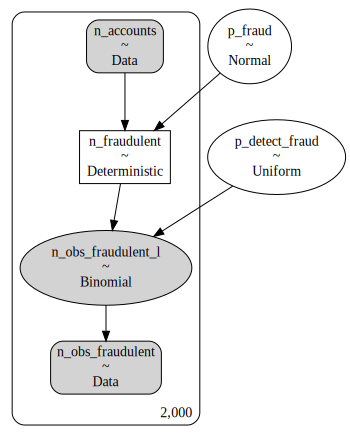

In [20]:
with pm.Model() as model1:
    # data
    n_accounts = pm.Data('n_accounts', dfm['n_accounts'].values)
    n_obs_fraudulent = pm.Data('n_obs_fraudulent', dfm['n_obs_fraudulent'].values)
    # priors
    # p_fraud actual = 0.25
    p_fraud = pm.Normal('p_fraud', 0.40, 0.10)
    # p_detect_fraud actual = 0.5
    p_detect_fraud = pm.Uniform('p_detect_fraud', 0.3, 0.7)
    # p_detect_fraud = 0.50
    # Process Model
    n_fraudulent = pm.Deterministic('n_fraudulent', n_accounts*p_fraud)
    n_obs_fraudulent_l = pm.Binomial('n_obs_fraudulent_l', n=n_fraudulent, p=p_detect_fraud, observed=n_obs_fraudulent)
    prior = pm.sample_prior_predictive()
    # trace = pm.sample(draws=2000, tune=2000)
    # post_pred = pm.sample_posterior_predictive(trace=trace)
    idata_model1 = az.from_pymc3(prior=prior)
pm.model_to_graphviz(model1)

In [21]:
# merge with original dataframe
# idata_model1.prior_predictive['n_obs_fraudulent_l'].to_dataframe().droplevel(0).reset_index()# .groupby(by='n_obs_fraudulent_l_dim_0').mean()

In [22]:
with model1:
    trace = pm.sample(draws=2000, tune=2000)
    # post_pred = pm.sample_posterior_predictive(trace=trace)
    # idata_model1.extend(az.from_pymc3(trace=trace, posterior_predictive=post_pred))
    idata_model1.extend(az.from_pymc3(trace=trace))

/tmp/ipykernel_1342942/3065835016.py:2: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p_detect_fraud, p_fraud]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 314 seconds.
There were 161 divergences after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There were 93 divergences after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There were 129 divergences after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There were 142 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


In [23]:
idata_model1

Inference data with groups:
	> prior
	> prior_predictive
	> observed_data
	> posterior
	> log_likelihood
	> sample_stats
	> constant_data

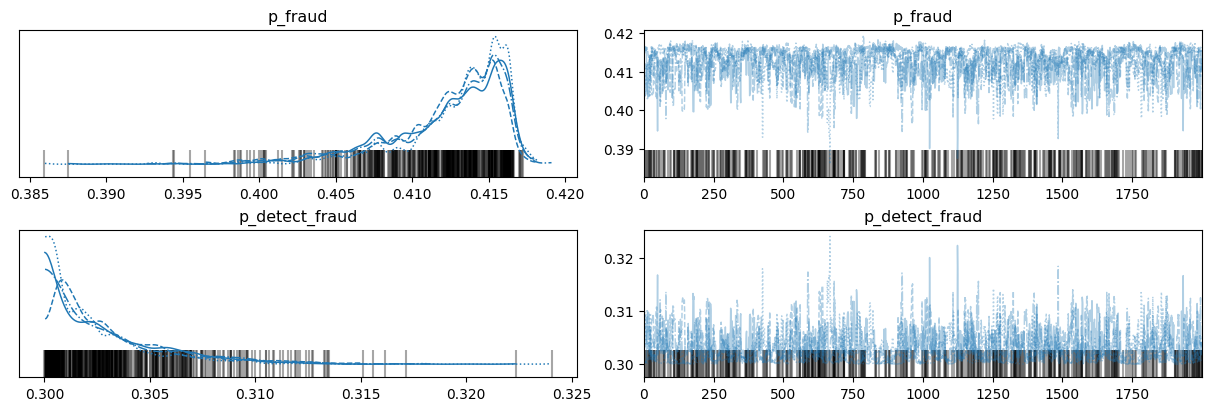

In [24]:
az.plot_trace(idata_model1, var_names=['p_fraud', 'p_detect_fraud']);

In [19]:
stop

NameError: name 'stop' is not defined

In [ ]:
p_detect_fraud = 0.50
p_fraud = 0.20
n_samples = 2000

n_accounts = [int(x) for x in pm.TruncatedNormal.dist(mu=900, sigma=200, lower=0).random(size=n_samples)]
n_fraudulent = pm.Binomial.dist(n=n_accounts, p=p_fraud).random(size=n_samples)
n_obs_fraudulent = pm.Binomial.dist(n_fraudulent, p=p_detect_fraud).random(size=n_samples)
df = pd.DataFrame({'n_accounts': n_accounts, 'n_fraudulent': n_fraudulent, 'n_obs_fraudulent': n_obs_fraudulent})
df['prop_fraudulent'] = df['n_fraudulent'] / df['n_accounts']
df

In [ ]:
df.describe()

In [ ]:
# Cut down the dataframe to only data that we can observe, so that we do not accidentally introduce something we cannot know in the real scenario
dfm = df.copy()[['n_accounts', 'n_obs_fraudulent']]

In [ ]:
# sns.scatterplot(data=dfm, x='n_obs_fraudulent', y='n_accounts')
# # plt.plot([0.0, 60], [0.0, 600], linewidth=0.5, linestyle='dashed', c='r'); #- # 45 degree line for reference
# plt.grid()

# Model 1

In [ ]:
with pm.Model() as model1:
    # data
    n_accounts = pm.Data('n_accounts', dfm['n_accounts'].values)
    n_obs_fraudulent = pm.Data('n_obs_fraudulent', dfm['n_obs_fraudulent'].values)
    # priors
    p_fraud = pm.Uniform('p_fraud', 0.05, 0.60)
    p_detect_fraud = pm.Uniform('p_detect_fraud', 0.05, 0.15)
    # Process Model
    n_fraudulent = pm.Binomial('n_fraudulent', n=n_accounts, p=p_fraud, shape=n_samples)
    n_obs_fraudulent_l = pm.Binomial('n_obs_fraudulent_l', n=n_fraudulent, p=p_detect_fraud, observed=n_obs_fraudulent)
    prior = pm.sample_prior_predictive()
    # trace = pm.sample(draws=2000, tune=2000)
    # post_pred = pm.sample_posterior_predictive(trace=trace)
    idata = az.from_pymc3(prior=prior)
pm.model_to_graphviz(model1)  

In [ ]:
idata

In [ ]:
# merge with original dataframe
idata.prior_predictive['n_obs_fraudulent_l'].to_dataframe().droplevel(0).reset_index()# .groupby(by='n_obs_fraudulent_l_dim_0').mean()

In [ ]:
# df_prior = pd.concat([dfm['n_accounts'], idata.prior_predictive['n_obs_fraudulent_l'].to_dataframe()], axis=1)
# sns.scatterplot(data=df_prior, x='n_obs_fraudulent', y='n_accounts')
# # plt.plot([0.0, 60], [0.0, 600], linewidth=0.5, linestyle='dashed', c='r'); #- # 45 degree line for reference
# plt.grid()

In [ ]:
with model1:
    trace = pm.sample(draws=2000, tune=2000)
    post_pred = pm.sample_posterior_predictive(trace=trace)
    idata.extend(az.from_pymc3(trace=trace, posterior_predictive=post_pred))

In [ ]:
idata

In [ ]:
az.plot_trace(idata, var_names=['p_fraud']);

In [ ]:
# On a particular day we see 1250 new accounts created, and we detect 30 fraudulent accounts - imaginary data
with model1:
    # data
    n_accounts = pm.set_data({'n_accounts': [1250]})
    n_obs_fraudulent = pm.set_data({'n_obs_fraudulent': [30]})
    # Pass in p_fraud, so thgat the model returns a posterior distribution for p_fraud based on the new data
    post_pred= pm.sample_posterior_predictive(trace, var_names=['p_fraud'])
    idata_oos = az.from_dict(post_pred)    

In [ ]:
idata_oos

In [ ]:
az.plot_trace(idata_oos, var_names=['p_fraud']);

# Model 2

In [ ]:
p_detect_fraud = 0.50
p_fraud = 0.20
n_samples = 2000

n_accounts = [int(x) for x in pm.TruncatedNormal.dist(mu=900, sigma=200, lower=0).random(size=n_samples)]
n_fraudulent = pm.Binomial.dist(n=n_accounts, p=p_fraud).random(size=n_samples)
n_obs_fraudulent = pm.Binomial.dist(n_fraudulent, p=p_detect_fraud).random(size=n_samples)
df = pd.DataFrame({'n_accounts': n_accounts, 'n_fraudulent': n_fraudulent, 'n_obs_fraudulent': n_obs_fraudulent})
# df['prop_fraudulent'] = df['n_fraudulent'] / df['n_accounts']
df

In [ ]:
df.describe()

In [ ]:
sns.scatterplot(data=df, x='n_obs_fraudulent', y='n_fraudulent')
# plt.plot([0.0, 60], [0.0, 600], linewidth=0.5, linestyle='dashed', c='r'); #- # 45 degree line for reference
plt.grid()

In [ ]:
sns.scatterplot(data=df, x='n_accounts', y='n_fraudulent')
# plt.plot([0.0, 60], [0.0, 600], linewidth=0.5, linestyle='dashed', c='r'); #- # 45 degree line for reference
plt.grid()

In [ ]:
sns.scatterplot(data=df, x='n_accounts', y='n_obs_fraudulent')
# plt.plot([0.0, 600], [0.0, 600], linewidth=0.5, linestyle='dashed', c='r'); #- # 45 degree line for reference
plt.grid()

In [ ]:
# n_fraudulent = pm.Binomial.dist(n=n_accounts, p=p_fraud).random(size=n_samples)
with pm.Model() as model2:
    # data
    n_accounts = pm.Data('n_accounts', dfm['n_accounts'].values)
    n_obs_fraudulent = pm.Data('n_obs_fraudulent', dfm['n_obs_fraudulent'].values)
    # priors
    p_fraud = pm.Uniform('p_fraud', 0.01, 0.6)
    intercept = pm.Uniform('intercept', -100, 100)
    slope = pm.Uniform('slope', 0, 1.0)
    sigma = pm.HalfNormal('sigma', 100)
    # process model
    # n_fraudulent = pm.Binomial('n_fraudulent', n=n_accounts, p=p_fraud, shape=n_samples)
    
    mu = pm.Deterministic('mu', intercept + slope*n_accounts)
    n_obs_fraudulent_l = pm.Normal('n_obs_fraudulent_l', mu, sigma, observed=n_obs_fraudulent)
    prior = pm.sample_prior_predictive()
    idata_model2 = az.from_pymc3(prior=prior)
pm.model_to_graphviz(model2)

In [ ]:
idata_model2

In [ ]:
with model1:
    trace = pm.sample(draws=2000, tune=2000)
    post_pred = pm.sample_posterior_predictive(trace=trace)
    idata_model2.extend(az.from_pymc3(trace=trace, posterior_predictive=post_pred))

In [ ]:
idata_model2

In [ ]:
az.plot_trace(idata_model2, var_names=['p_fraud']

# Model 3

In [ ]:
p_detect_fraud = 0.50
p_fraud = 0.20
n_samples = 2000

n_accounts = [int(x) for x in pm.TruncatedNormal.dist(mu=900, sigma=200, lower=0).random(size=n_samples)]
n_fraudulent = pm.Binomial.dist(n=n_accounts, p=p_fraud).random(size=n_samples)
n_obs_fraudulent = pm.Binomial.dist(n_fraudulent, p=p_detect_fraud).random(size=n_samples)
df = pd.DataFrame({'day': range(n_samples), 'n_accounts': n_accounts, 'n_fraudulent': n_fraudulent, 'n_obs_fraudulent': n_obs_fraudulent})
df

+ The data we get to see is n_accounts, and n_obs_fraudulent
+ We know p(obs_fraudulent) = n_obs_fraudulent / n_accounts
+ p(obs_fraudulent) = p(fraudulent) * p(detected | fraudulent)
+ If first row looks like this:
    + n_accounts: 438, n_fraudulent: 85, n_obs_fraudulent: 45
+ p(fraudulent) = 85 / 438 = 0.194
+ p(detected | fraudulent) = 45 / 85 = 0.529
+ p(obs_fraudulent) = 45 / 438 = 0.103 = 0.194 * 0.529 = 0.103
+ So, 
+ And
+ n_fraudulent = p(fraudulent) * n_accounts
+ So,
+ n_fraudulent = (p(obs_fraudulent) / p(detected | fraudulent)) * n_accounts

In [ ]:
# with pm.Model() as model1:
#     # data
#     n_accounts = pm.Data('n_accounts', dfm['n_accounts'].values)
#     n_obs_fraudulent = pm.Data('n_obs_fraudulent', dfm['n_obs_fraudulent'].values)
#     # priors
#     p_fraud = pm.Uniform('p_fraud', 0.05, 0.60)
#     p_detect_fraud = pm.Uniform('p_detect_fraud', 0.05, 0.15)
#     # Process Model
#     n_fraudulent = pm.Binomial('n_fraudulent', n=n_accounts, p=p_fraud, shape=n_samples)
#     n_obs_fraudulent_l = pm.Binomial('n_obs_fraudulent_l', n=n_fraudulent, p=p_detect_fraud, observed=n_obs_fraudulent)
#     prior = pm.sample_prior_predictive()
#     # trace = pm.sample(draws=2000, tune=2000)
#     # post_pred = pm.sample_posterior_predictive(trace=trace)
#     idata = az.from_pymc3(prior=prior)
# pm.model_to_graphviz(model1)  

with pm.Model() as model3:
    n_accounts = pm.Data('n_accounts', dfm['n_accounts'].values)
    # n_obs_fraudulent = pm.Data('n_obs_fraudulent', dfm['n_obs_fraudulent'].values)
    p_obs_fraudulent = pm.Data('p_obs_fraudulent', (dfm['n_obs_fraudulent']/dfm['n_accounts']).values)
    # priors
    p_fraudulent = pm.Uniform('p_fraudulent', 0.05, 0.50)
    p_detected = pm.Uniform('p_detected', 0.05, 0.9)
    # process model
    p_obs_fraudulent_l = pm.Binomial('p_obs_fraudulent_l', n=n_accounts, p=p_fraudulent * p_detected, observed=p_obs_fraudulent)
    prior = pm.sample_prior_predictive()
    trace = pm.sample()
    idata_model3 = az.from_pymc3(prior=prior, trace=trace)
pm.model_to_graphviz(model3)    

In [ ]:
idata_model3

In [ ]:
az.plot_trace(idata_model3, var_names=['p_fraudulent'])

In [ ]:
with pm.Model() as model2:
    # data
    n_accounts = pm.Data('n_accounts', dfm['n_accounts'].values)
    n_obs_fraudulent = pm.Data('n_obs_fraudulent', dfm['n_obs_fraudulent'].values)
    # priors
    p_fraud = pm.Uniform('p_fraud', 0.05, 0.60)
    p_detect_fraud = pm.Uniform('p_detect_fraud', 0.05, 0.15)
    sigma = pm.HalfNormal(50)
    # Process Model
    n_fraudulent = pm.Binomial('n_fraudulent', n=n_accounts, p=p_fraud, shape=n_samples)
    n_obs_fraudulent_l = pm.Normal('n_obs_fraudulent_l', n=n_fraudulent, p=p_detect_fraud, observed=n_obs_fraudulent)
    prior = pm.sample_prior_predictive()
    # trace = pm.sample(draws=2000, tune=2000)
    # post_pred = pm.sample_posterior_predictive(trace=trace)
    idata = az.from_pymc3(prior=prior)
pm.model_to_graphviz(model1)    

In [ ]:
stop

In [ ]:
# import pymc3 as pm
# import matplotlib.pyplot as plt

# from scipy.stats import binom

# p_true = 0.37
# n = 10000
# K = 50

# X = binom.rvs( n=n, p=p_true, size=K )
# print( X )

# model = pm.Model()

# with model:
#     # p = pm.Beta( 'p', alpha=2, beta=2 )
#     p = pm.Uniform('p', 0.2, 0.4)
#     y_obs = pm.Binomial( 'y_obs', p=p, n=n, observed=X )
#     step = pm.Metropolis()
#     trace = pm.sample( 10000, step=step, progressbar=True )

# pm.traceplot( trace )
# plt.show()


In [ ]:
stop

---

# Original notebook

In [ ]:
from scipy import stats

In [ ]:
n_observations = 1000

true_orange_mu, true_orange_sd = 300, 100
true_green_mu, true_green_sd = 600, 200

# Fraction of each class that will be observed.
obs_pct_orange_mu, obs_pct_orange_sd = 0.10, 0.05
obs_pct_green_mu, obs_pct_green_sd = 0.40, 0.10

# Setup lower bounds on the distributions
a1 = - (true_orange_mu - 0 ) / true_orange_sd
a2 = - (true_green_mu - 0 ) / true_green_sd
a3 = - (obs_pct_orange_mu - 0 ) / obs_pct_orange_sd 
a4 = - (obs_pct_green_mu - 0 ) / obs_pct_green_sd 
print(a1, a2, a3, a4)

df = pd.DataFrame(
    dict(
        # https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.truncnorm.html
        true_orange=stats.truncnorm.rvs(a=a1, b=100, loc=true_orange_mu, scale=true_orange_sd, size=n_observations),
        true_green=stats.truncnorm.rvs(a=a2, b=100, loc=true_green_mu, scale=true_green_sd, size=n_observations),
        # true_orange=np.random.normal(true_orange_mu, true_orange_sd, size=n_observations),
        # true_green=np.random.normal(true_green_mu, true_green_sd, size=n_observations),
        pct_obs_orange=stats.truncnorm.rvs(a=a3, b=np.inf, loc=obs_pct_orange_mu, scale=obs_pct_orange_sd, size=n_observations),
        pct_obs_green=stats.truncnorm.rvs(a=a4, b=np.inf, loc=obs_pct_green_mu, scale=obs_pct_green_sd, size=n_observations),
    ),
    columns=['true_orange', 'true_green', 'pct_obs_orange', 'pct_obs_green']
)
df['true_orange'] = df['true_orange'].astype(int)
df['true_green'] = df['true_green'].astype(int)
df['total'] = df['true_orange'] + df['true_green']
df['pct_orange'] = df['true_orange'] / df['total']
df['obs_orange'] = (df['true_orange'] * df['pct_obs_orange']).astype(int)# .clip(lower=0)
df['obs_green'] = (df['true_green'] * df['pct_obs_green']).astype(int)# .clip(lower=0)

# df.drop(['pct_obs_orange', 'pct_obs_green'], axis=1, inplace=True)
# df = df.round().astype(int)
df

In [ ]:
df.describe()

In [ ]:
sns.histplot(df['pct_orange'], stat='count', discrete=False, alpha=0.5);

In [ ]:
sns.histplot(df['pct_obs_orange'], stat='count', discrete=False, alpha=0.5);

In [ ]:
sns.scatterplot(data=df, x='pct_obs_orange', y='pct_orange')
plt.grid()

In [ ]:
df = df[['true_orange', 'true_green', 'total', 'obs_orange', 'obs_green']]

## Model of process with PyMC

### Using only 10 observations

In [ ]:
data_df_10 = df[:10]
data_df_10

In [ ]:
no_upper_bounds = np.matrix(np.ones((len(data_df_10),1)) * np.inf)
no_upper_bounds

In [ ]:
with pm.Model() as m10:
    # obs_data_m1 = pm.MutableData("obs_data_m1", df)
    
    no_upper_bounds = np.matrix(np.ones((len(data_df_10),1)) * np.inf)
    
    mu_orange = pm.Uniform("mu_orange", 100, 500)
    sd_orange = pm.HalfNormal("sd_orange", 150)
    orange_daily = pm.Normal("orange_daily", mu_orange, sd_orange)
                             
    mu_green = pm.Uniform("mu_green", 300, 1000)
    sd_green = pm.HalfNormal("sd_green", 300)
    green_daily = pm.Normal("green_daily", mu_green, sd_green)
    
    # Use observed number of orange and green to put a lower bound on modeled # of orange.
    daily_mu_with_obs = (
        pm.math.clip(orange_daily, data_df_10['obs_orange'], no_upper_bounds)
        +
        pm.math.clip(green_daily, data_df_10['obs_green'], no_upper_bounds)
    )
        
    daily_total = pm.Normal(
        "daily_total", 
        orange_daily + green_daily, 
        # Introducing a noise term here, since observed data can not be directly applied
        # to a deterministic node, but otherwise I would use Deterministic here.
        .001, 
        observed=data_df_10['total']
    )
    
    trace_m10 = pm.sample(1_000, chains=4, target_accept=0.9)

In [ ]:
az.plot_posterior(trace_m10)

### With 100 observations

In [ ]:
data_df_100 = df[:100]
data_df_100

In [ ]:
with pm.Model() as m100:
    # obs_data_m1 = pm.MutableData("obs_data_m1", df)
    
    no_upper_bounds = np.matrix(np.ones((len(data_df_100),1)) * np.inf)
    
    mu_orange = pm.Uniform("mu_orange", 100, 500)
    sd_orange = pm.HalfNormal("sd_orange", 150)
    orange_daily = pm.Normal("orange_daily", mu_orange, sd_orange)
                             
    mu_green = pm.Uniform("mu_green", 300, 1000)
    sd_green = pm.HalfNormal("sd_green", 300)
    green_daily = pm.Normal("green_daily", mu_green, sd_green)
    
    # Use observed number of orange and green to put a lower bound on modeled # of orange.
    daily_mu_with_obs = (
        pm.math.clip(orange_daily, data_df_100['obs_orange'], no_upper_bounds)
        +
        pm.math.clip(green_daily, data_df_100['obs_green'], no_upper_bounds)
    )
        
    daily_total = pm.Normal(
        "daily_total", 
        orange_daily + green_daily, 
        # Introducing a noise term here, since observed data can not be directly applied
        # to a deterministic node, but otherwise I would use Deterministic here.
        .001, 
        observed=data_df_100['total']
    )
    
    trace_m100 = pm.sample(1_000, chains=4, target_accept=0.9)

In [ ]:
az.plot_posterior(trace_m100)

### With all 1000 observations

In [ ]:
data_df_1000 = df[:1000]
data_df_1000

In [ ]:
with pm.Model() as m1000:
    # obs_data_m1 = pm.MutableData("obs_data_m1", df)
    
    no_upper_bounds = np.matrix(np.ones((len(data_df_1000),1)) * np.inf)
    
    mu_orange = pm.Uniform("mu_orange", 100, 500)
    sd_orange = pm.HalfNormal("sd_orange", 150)
    orange_daily = pm.Normal("orange_daily", mu_orange, sd_orange)
                             
    mu_green = pm.Uniform("mu_green", 300, 1000)
    sd_green = pm.HalfNormal("sd_green", 300)
    green_daily = pm.Normal("green_daily", mu_green, sd_green)
    
    # Use observed number of orange and green to put a lower bound on modeled # of orange.
    daily_mu_with_obs = (
        pm.math.clip(orange_daily, data_df_1000['obs_orange'], no_upper_bounds)
        +
        pm.math.clip(green_daily, data_df_1000['obs_green'], no_upper_bounds)
    )
        
    daily_total = pm.Normal(
        "daily_total", 
        orange_daily + green_daily, 
        # Introducing a noise term here, since observed data can not be directly applied
        # to a deterministic node, but otherwise I would use Deterministic here.
        .001, 
        observed=data_df_1000['total']
    )
    
    trace_m1000 = pm.sample(1_000, chains=4, target_accept=0.9)

In [ ]:
az.plot_posterior(trace_m1000)